In [1]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec

nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Mihaela
[nltk_data]     Stoycheva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Functions

In [3]:
def load_data(filename, max_sentence_len):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename) as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [4]:
def tokenize_sentence(string, max_sentence_len):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    return sentence, padded_sentence

In [5]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Load Penn Treebank data

In [6]:
# max_sentence_length = 50
# train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
# val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
# test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

### Load Synthetic data

In [7]:
test_syn_data = np.loadtxt('./synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('./synthetic-data/synthetic_train.txt', dtype=int)

In [8]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)
val_inputs, val_targets = get_batches_synthetic(test_syn_data, batch_size)

### Encoder-decoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [10]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden

### VAE

In [11]:
# class Stochastic(nn.Module):
#     def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
#         super(Stochastic, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
# #         if synthetic:          
# #             for param in self.parameters():
# #                 nn.init.uniform_(param, -0.01, 0.01)

#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def forward(self, hidden_concatenated):
#         mean = self.hidden_to_mean(hidden_concatenated)
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden_concatenated = self.latent_to_hidden(z)
#         return hidden_concatenated, mean, log_variance

In [12]:
class StochasticEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        return z, mean, log_variance

In [13]:
class StochasticDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def forward(self, z):
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated

In [14]:
# # new VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
#         self.stochastic = Stochastic(self.hidden_dim, num_layers, self.latent_dim, synthetic)
#         self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
#         # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
#         ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
#         ## with this distribution it (kind of) works both without annealing and with annealing 
#         ## (why??? who knows)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
    
#     def latent_to_hidden(self, x):
#         return self.stochastic.latent_to_hidden(x)
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs
    
#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
#         hidden_concatenated, mean, log_variance = self.stochastic(hidden_concatenated)
#         hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [15]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic_encoder = StochasticEncoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.stochastic_decoder = StochasticDecoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, z):
        return self.stochastic_decoder.latent_to_hidden(z)
        
    def decode(self, hidden, x, x_lens=None, train=True):
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs       
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        z, mean, log_variance = self.stochastic_encoder.forward(hidden_concatenated)
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs
    
    def calc_mi(self, x):
        """Approximate the mutual information between x and z
        I(x, z) = E_xE_{q(z|x)}log(q(z|x)) - E_xE_{q(z|x)}log(q(z))
        Returns: Float
        """
        mean, log_variance, _ = self.forward(x)
        _, batch_size, _ = mean.size()

        # E_{q(z|x)}log(q(z|x)) = -0.5*nz*log(2*\pi) - 0.5*(1+logvar).sum(-1)
        neg_entropy = (-0.5 * self.latent_dim * np.log(2 * np.pi)- 0.5 * (1 + log_variance).sum(-1)).mean()

        # [z_batch, 1, nz]
        z = self.stochastic_encoder.reparametrize(mean, log_variance)

        # [1, x_batch, nz]
        mean, log_variance = mean.unsqueeze(0), log_variance.unsqueeze(0)

        # (z_batch, x_batch, nz)

        # (z_batch, x_batch)
        log_density = -0.5 * (((z - mean) ** 2) / log_variance.exp()).sum(dim=-1) - \
            0.5 * (self.latent_dim * np.log(2 * np.pi) + log_variance.sum(-1))

        # log q(z): aggregate posterior
        # [z_batch]
        log_qz = log_sum_exp(log_density, dim=1) - np.log(batch_size)

        return (neg_entropy - log_qz.mean(-1)).item()

In [20]:
# # old VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.decoder = Decoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs

#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
#         mean = self.hidden_to_mean(hidden_concatenated)
        
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden = self.latent_to_hidden(z)
        
#         hidden = torch.split(hidden, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [21]:
def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
    BCE = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) 
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    BCE = BCE / mean.shape[1]  # divide by batch size
    KLD /= mean.shape[1]
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

In [22]:
def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
    BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels).view(mean.shape[1], -1).sum(-1)
    KLD = -0.5 * (1 + log_variance - mean.pow(2) - log_variance.exp()).permute(1, 0, 2).squeeze(-1).squeeze(-1)
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

### True posterior

In [23]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [24]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, iteration=None):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    vae.eval()
    approximate_mean, _, _ = vae.forward(tracked_inputs)
    vae.train()
    plt.figure(figsize=(5,5))
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true postrior mean")
    plt.ylabel("approximate posterior mean")
    if iteration is not None:
        plt.title("iteration {0}".format(iteration))
    plt.show()

def plot_kl(kl_terms, kl_weights):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(x_axis, kl_terms[::plot_step], label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="orange", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_losses(total_loss, ce_loss, kl_loss):
    plot_step = 10
    x_axis = np.arange(len(total_loss[::plot_step])) * plot_step
    total_loss = np.array(total_loss[::plot_step])
    kl_loss = np.array(kl_loss[::plot_step])
    fig, ax1 = plt.subplots(figsize=(8,4))
    plt.fill_between(x_axis, np.zeros(len(x_axis)), total_loss, label="total loss")
    plt.fill_between(x_axis, np.zeros(len(x_axis)), kl_loss, label="kl loss")
    plt.xlabel("loss")
    plt.ylabel("iteration")
    plt.legend()
    plt.show()

## Experiments

In [25]:
def train(vae, inputs, targets, validation_data, epochs, vocab_size, hidden_size, latent_size, input_lens=None, synthetic=False, 
          num_layers=1, step=1.0, learning_rate=0.001, tracked_inputs=None, tracked_targets=None, annealing_args=None, 
          is_aggressive=False, plot=False, plot_lim=1.5, verbose=True):
    
    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = 0
    total_losses = []
    ce_losses = []
    kl_losses = []
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
    
    previous_mi = -1
        
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            
            inner_iter = 1
            random_i = i
            
            burn_num_words = 0
            burn_pre_loss = 1e4
            burn_cur_loss = 0
            while is_aggressive and inner_iter < 100:
                x = inputs[random_i]
                y = torch.tensor(targets[random_i].reshape(-1), dtype=torch.long)
                x_lens = input_lens[random_i] if not synthetic else None
                
                enc_optimizer.zero_grad()
                stoch_enc_optimizer.zero_grad()
                stoch_dec_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                
                burn_batch_size, burn_sents_len, _ = x.shape
                burn_num_words += burn_sents_len * burn_batch_size
              
                mean, log_variance, outputs = vae(x, x_lens=x_lens)
                if not synthetic:
                    mask = (y < padding_index)
                    outputs = outputs[mask]
                    y = y[mask]
    
                loss_summary = loss_function(outputs, y, mean, log_variance, annealing_args=annealing_args)
                
                loss = loss_summary[0]
                burn_cur_loss += loss.sum().item()
                
                loss = loss.mean(dim=-1)
                loss.backward()
                
                clip_grad_norm_(vae.parameters(), 5.0)
                
                stoch_enc_optimizer.step()
                enc_optimizer.step()
                random_i = np.random.randint(0, len(inputs)- 1)
                if inner_iter % 15 == 0:
                    burn_cur_loss = burn_cur_loss / burn_num_words
                    if burn_pre_loss - burn_cur_loss < 0:
                        break
                    burn_pre_loss = burn_cur_loss
                    burn_cur_loss = burn_num_words = 0
                inner_iter += 1
              
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None  
            
            mean, log_variance, outputs = vae(x, x_lens=x_lens)
            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]

            loss_summary = loss_function(outputs, y, mean, log_variance, annealing_args=annealing_args)
#             total_losses.append(loss_summary[0].data.item())
#             ce_losses.append(loss_summary[1].data.item())
#             kl_losses.append(loss_summary[3].data.item())
            
            loss = loss_summary[0]
                
            loss = loss.mean(dim=-1)
            
#             if annealing_args is not None:
#                 kl_terms.append(loss_summary[2].data.item())
#                 kl_weights.append(loss_summary[4])     
            
            enc_optimizer.zero_grad()
            stoch_enc_optimizer.zero_grad()
            stoch_dec_optimizer.zero_grad()
            dec_optimizer.zero_grad()
#             vae_optimizer.zero_grad()
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
            dec_optimizer.step()
            stoch_dec_optimizer.step()
            if not is_aggressive:
                stoch_enc_optimizer.step()
                enc_optimizer.step()
            #vae_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weighted KL: {:.3f} weight {:.3f}'.format(epoch+1, 
                            iteration, loss, loss_summary[1].mean(dim=-1).data.item(), \
                            loss_summary[2].mean(dim=-1).data.item(), \
                            loss_summary[3].mean(dim=-1).data.item(), loss_summary[4]))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration
        
        if is_aggressive:
            vae.eval()
            current_mi = calc_mi(vae, validation_data)
            vae.train()
            print('current_mi:', current_mi)
            if current_mi - previous_mi < 0:
                is_aggressive = False
                print("STOP AGGRESSIVE")

            previous_mi = current_mi
                
        if (epoch % 1 == 0) and plot:
            plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
       
    
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}\n'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))
    
    if annealing_args is not None:
        plot_kl(kl_terms, kl_weights)
    plot_losses(total_losses, ce_losses, kl_losses)
    
def calc_mi(model, test_data_batch):
    mi = 0
    num_examples = 0
    for batch_data in test_data_batch:
        batch_size = batch_data.shape[0]
        num_examples += batch_size
        mutual_info = model.calc_mi(batch_data)
        mi += mutual_info * batch_size

    return mi / num_examples

### Synthetic data

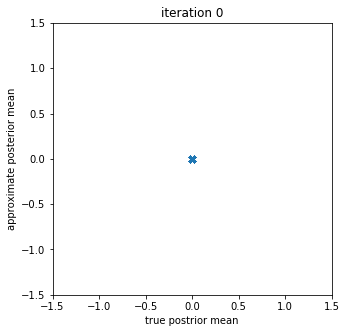

KeyboardInterrupt: 

In [43]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5)

In [ ]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

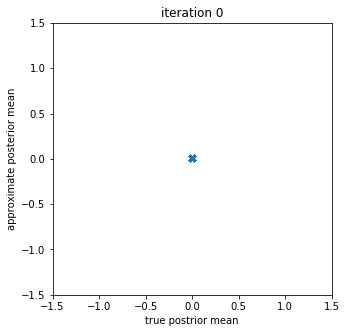

epoch 1 iteration 0 loss 62.180 CE 62.180 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 46.218 CE 46.218 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 200 loss 43.401 CE 43.382 KL 0.018 weighted KL: 0.018 weight 1.000
epoch 1 iteration 300 loss 34.366 CE 33.282 KL 1.083 weighted KL: 1.083 weight 1.000
epoch 1 iteration 400 loss 31.306 CE 29.813 KL 1.493 weighted KL: 1.493 weight 1.000
epoch 1 iteration 500 loss 41.229 CE 39.753 KL 1.476 weighted KL: 1.476 weight 1.000
epoch 1 iteration 600 loss 34.690 CE 33.192 KL 1.497 weighted KL: 1.497 weight 1.000
epoch 1 iteration 700 loss 35.933 CE 34.389 KL 1.544 weighted KL: 1.544 weight 1.000
epoch 1 iteration 800 loss 32.431 CE 30.696 KL 1.734 weighted KL: 1.734 weight 1.000
epoch 1 iteration 900 loss 32.792 CE 31.283 KL 1.509 weighted KL: 1.509 weight 1.000
current_mi: 2.7813310928344728


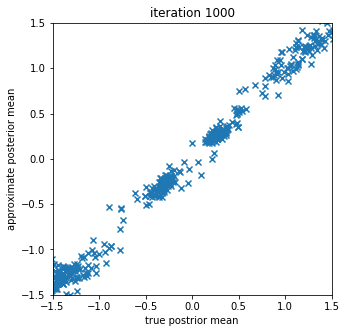

Epoch [1/10], Loss: 39.7861, Perplexity: 190058805975092864.00

epoch 2 iteration 1000 loss 34.640 CE 33.069 KL 1.571 weighted KL: 1.571 weight 1.000


KeyboardInterrupt: 

In [28]:
# aggresive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5, is_aggressive=True)

# TEXT DATA

### Create Word2Vec word embeddings

In [ ]:
embedding_size = 500
num_epochs_to_train = 10

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=num_epochs_to_train, total_examples=word2vec_model.corpus_count)

word2vec_model.wv.most_similar("stocks")
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
print("size of the vocabulary:", vocabulary_size)
word2vec_model.save("word2vec.model")

### Define RNNLM

In [ ]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [ ]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 10

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

In [ ]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])